## Лабораторная работа 2. Линейные модели

Некоторые задачи в этом ноутбуке надо будет сдавать в [контест](https://contest.yandex.ru/contest/68191/enter). Когда сдаете туда код, не забудьте сверху прописать все нужные импорты.

> Мы рассчитываем, что перед тем, как садиться за этот ноутбук, вы прослушали лекции про МНК, регрессию и регуляризацию или прочитали часть про регрессию главы "Линейные модели" ШАДовского учебника по ML.

Начнём с загрузки необходимых библиотек и функций.
Параметр `seed` будет использоваться далее для инициализации генератора случайных чисел из библиотеки `numpy`.

In [1]:
import numpy as np
import pandas as pd
from typing import Optional, List

import sklearn.base
from sklearn.model_selection import train_test_split

from sklearn.base import TransformerMixin
from sklearn.base import RegressorMixin

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

seed = 24

В этом ноутбуке мы будем практиковаться на датасете ["The Ames Iowa Housing Data"](https://www.openml.org/d/41211). Здесь собраны описания и цены жилья в городе Эймс, штат Айова. Мы будем решать задачу предсказания цены (`Sale_Price`) по всем остальным признакам.

И начнём мы, конечно, с того, что внимательно посмотрим на датасет: какие там есть объекты и какие признаки.

In [2]:
## Uncomment the line below to download data and install necessary packages
## Maybe won't work on Windows :(

# !pip install numpy pandas scikit-learn matplotlib
# !curl https://api.openml.org/data/get_csv/20649135/file2ed11cebe25.arff > data.csv
# эта ссылка выдает пустой .csv

In [3]:
data = pd.read_csv('data/data.csv')

data.sample(20)

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
2067,One_and_Half_Story_Finished_All_Ages,Residential_Low_Density,70,6960,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,NaN,0,7,2007,WD,Normal,165250,-93.660691,42.032638
1029,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,80,10400,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Good_Wood,NaN,0,4,2008,WD,Normal,159900,-93.635216,42.049449
2389,Two_Story_1946_and_Newer,Residential_Low_Density,80,10240,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Fence,NaN,0,3,2006,WD,Normal,275500,-93.653016,42.060835
114,Two_Story_1946_and_Newer,Residential_Low_Density,80,10421,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,Shed,500,3,2010,WD,Normal,196500,-93.637788,42.043329
106,One_Story_PUD_1946_and_Newer,Residential_Low_Density,30,4420,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,CulDSac,...,No_Fence,NaN,0,6,2010,WD,Normal,155000,-93.649361,42.042565
1079,One_Story_PUD_1946_and_Newer,Residential_Medium_Density,59,8198,Pave,No_Alley_Access,Regular,Lvl,AllPub,FR3,...,No_Fence,NaN,0,7,2008,WD,Normal,207000,-93.650890,42.056616
1053,Two_Story_1946_and_Newer,Residential_Low_Density,67,14948,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Fence,NaN,0,11,2008,New,Partial,446261,-93.652744,42.062925
997,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,53,14137,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Fence,NaN,0,11,2008,WD,Normal,177900,-93.636718,42.060639
1649,Two_Story_1946_and_Newer,Residential_Low_Density,92,11952,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Fence,NaN,0,11,2007,WD,Normal,190000,-93.633973,42.055217
2084,One_Story_PUD_1946_and_Newer,Residential_Low_Density,39,3869,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Fence,NaN,0,7,2007,WD,Normal,130000,-93.664314,42.024687


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 81 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_SubClass         2930 non-null   object 
 1   MS_Zoning           2930 non-null   object 
 2   Lot_Frontage        2930 non-null   int64  
 3   Lot_Area            2930 non-null   int64  
 4   Street              2930 non-null   object 
 5   Alley               2930 non-null   object 
 6   Lot_Shape           2930 non-null   object 
 7   Land_Contour        2930 non-null   object 
 8   Utilities           2930 non-null   object 
 9   Lot_Config          2930 non-null   object 
 10  Land_Slope          2930 non-null   object 
 11  Neighborhood        2930 non-null   object 
 12  Condition_1         2930 non-null   object 
 13  Condition_2         2930 non-null   object 
 14  Bldg_Type           2930 non-null   object 
 15  House_Style         2930 non-null   object 
 16  Overal

Разобьём данные на обучающую и тестовую выборки.

In [5]:
target_column = "Sale_Price"
np.random.seed(seed)

test_size = 0.2
data_train, data_test, Y_train, Y_test = train_test_split(
    data[data.columns.drop("Sale_Price")],
    np.array(data["Sale_Price"]),
    test_size=test_size,
    random_state=seed)

print(f"Train : {data_train.shape} {Y_train.shape}")
print(f"Test : {data_test.shape} {Y_test.shape}")

Train : (2344, 80) (2344,)
Test : (586, 80) (586,)


Среди признаков нам встретятся как вещественные, так и категориальные. Пока что выделим в качестве категориальных те, значениями которых являются не числа, а какие-то другие сущности. Но имейте в виду, что численные с виду признаки тоже могут быть категориальными.

In [6]:
continuous_columns = [key for key in data.keys() if data[key].dtype in ("int64", "float64")]
categorical_columns = [key for key in data.keys() if data[key].dtype == "object"]

continuous_columns.remove(target_column)

print(f"Continuous : {len(continuous_columns)}, Categorical : {len(categorical_columns)}")

Continuous : 34, Categorical : 46


Посмотрим на заголовки признаков. В целом, многие названия вполне говорящие, и можно догадаться, что стоит за этими признаками.

In [7]:
continuous_columns

['Lot_Frontage',
 'Lot_Area',
 'Year_Built',
 'Year_Remod_Add',
 'Mas_Vnr_Area',
 'BsmtFin_SF_1',
 'BsmtFin_SF_2',
 'Bsmt_Unf_SF',
 'Total_Bsmt_SF',
 'First_Flr_SF',
 'Second_Flr_SF',
 'Low_Qual_Fin_SF',
 'Gr_Liv_Area',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath',
 'Full_Bath',
 'Half_Bath',
 'Bedroom_AbvGr',
 'Kitchen_AbvGr',
 'TotRms_AbvGrd',
 'Fireplaces',
 'Garage_Cars',
 'Garage_Area',
 'Wood_Deck_SF',
 'Open_Porch_SF',
 'Enclosed_Porch',
 'Three_season_porch',
 'Screen_Porch',
 'Pool_Area',
 'Misc_Val',
 'Mo_Sold',
 'Year_Sold',
 'Longitude',
 'Latitude']

Одна из целей этого ноутбука — познакомить вас с fit-predict (fit-transform) интерфейсом, типичным для многих реализаций моделей машинного обучения и для различных инструментов работы с данными.

Множество фреймворков машинного обучения (например, scikit-learn, CatBoost) содержат в себе модели, которые описаны в виде классов, у которых есть два ключевых метода: `fit` и `predict` (`transform`). Давайте разберёмся, что делают эти методы.

* **`fit`** — метод для обучения модели. Он получает на входе данные и таргеты для обучения, после чего обновляет состояние класса. После использования метода fit считается, что объект класса готов к использованию. Внутри этого метода может быть что угодно: обучение модели, подбор гиперпараметров, подсчет статистик и т. д.

* **`predict`** — метод для предсказания , обученного с помощью `fit`. В задаче регрессии это оценка параметра, в задаче классификации предсказанный класс.

* **`transform`** — стилистический синоним `predict`, но используется в классах, которые реализуют преобразования данных, например, масштабирование признаков или кодирование категориальных фичей.

* **`fit_transform`** — метод который учится на данных, а потом их же преобразовывает.

### 1. Базовая предобработка данных

Отметим два важных свойства линейной регрессии:

- строго говоря, она умеет работать только с вещественными признаками
- если признаки имеют разный масштаб, то регуляризация может штрафовать коэффициенты за несоответствие.

Первое соображение заставляет придумывать способы борьбы с категориальными признаками, и мы начнём с самого простого: проигнорируем их.
Второе соображение приводит к необходимости приводить признаки к одному масштабу ("нормализовать фичи"). В `sklearn` для этого есть два основных класса:

- [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) &mdash; в каждой колонке вычитает среднее и делит на стандартное отклонение.
- [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) &mdash; в каждой колонке вычитает минимальное значение и делит на разницу между минимальным и максимальным.

Применяются они в соответствии с описанной выше философией. Например:

```
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```

Обратите внимание, что scaler настраивается на обучающей выборке (именно по ней вычисляются среднее и стандартное отклонение), а к тестовой он применяется с уже подсчитанными статистиками.

**Вопрос**. А зачем? Почему бы не нормировать отдельно обучающую и тестовую выборку? Почему бы не настроить наш scaler на объединении двух выборок? Ведь благодаря большему количеству данных мы бы настроили его точнее!
<p>
<details>
  <summary>Кликните, чтобы узнать ответ</summary>

Если мы по-разному отнормируем обучающую и тестовую выборки, то нам будет весьма сложно применять модель, обученную на одной из них, к другой. Это просто не будет иметь физического смысла.

Настраивать что-либо на тестовой выборке — это очень плохая идея. Тестовая выборка должна быть неким независимым мерилом качества наших усилий по предсказанию, а если мы разрешим информации о распределении признаков в тестовой выборке "протечь" в процесс обучения, то мы эту независимость испортим.

</details>

Итак, мы решили делать преобразование данных, которое состоит в:

- сохранении лишь непрерывных фичей;
- нормализации этих фичей (давайте остановимся на [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html))

В этом пункте вам нужно будет сделать класс такой предобработки данных, причём оформим мы его в виде класса с интерфейсом fit-transform.

Несколько важных соображений:

1. В прошлой лабораторной метод fit у нас ничего не возвращал, но правильнее сделать так, чтобы метод fit возвращал сам класс. В частности, это позволит нам писать model = model.fit().

2. Первоначальный анализ данных удобно делать, когда они лежат в pd.DataFrame, т к у этого класса много методов, которые малым количеством телодвижений позволяют считать статистики и строить графики. Модели же проще учить, когда данные лежат в np.array, потому большое количество библиотек, где реализованы методы машинного обучения совместимы именно с numpy. Поэтому сделайте так, чтобы метод transform получал на вход pd.Dataframe, а возвращал np.array.

3. В sklearn есть классы, от которых можно отнаследоваться, чтобы сделать класс с [fit-predict](https://scikit-learn.org/stable/modules/generated/sklearn.base.RegressorMixin.html#sklearn.base.RegressorMixin) или [fit-transform](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) интерфейсом. Это очень полезно, т к позволит вам в дальнейшем пользоваться методами [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) и подобными. В этом пункте отнаследуйтесь от второго.

4. У метода __init__ должен быть параметр ```needed_columns=None```. Туда передается список колонок, которые нужно взять из датафрейме. Делать это надо в ```fit``` и ```transform```. В случае если если он равен None, то класс оставляет все колонки из исходного набора данных.

5. Обратите внимание, что достаточно реализовать `fit` и `transform`, а метод `fit_transform` из них слепит родительский класс.

**Готовый препроцессор вам нужно будет сдать в Контест**

In [8]:
class BaseDataPreprocessor(TransformerMixin):
    def __init__(self, needed_columns: Optional[List[str]]=None):
        """
        :param needed_columns: if not None select these columns from the dataframe
        """
        self.scaler = StandardScaler()
        self.needed_columns = needed_columns

    def fit(self, data, *args):
        """
        Prepares the class for future transformations
        :param data: pd.DataFrame with all available columns
        :return: self
        """
        self.data = data[self.needed_columns] if self.needed_columns else data
        self.scaler.fit(self.data)
        return self

    def transform(self, data: pd.DataFrame) -> np.array:
        """
        Transforms features so that they can be fed into the regressors
        :param data: pd.DataFrame with all available columns
        :return: np.array with preprocessed features
        """
        return self.scaler.transform(data[self.needed_columns] if self.needed_columns else data)

**1. (1 балл)** Сдайте вашу реализацию в Контест, задача «Простая предобработка».

In [9]:
# preprocessor = BaseDataPreprocessor(needed_columns=continuous_columns)
preprocessor = BaseDataPreprocessor(needed_columns=continuous_columns)

preprocessor.fit(data_train)

X_train = preprocessor.transform(data_train)
X_test = preprocessor.transform(data_test)

### 1.2 Умная предобработка данных

Теперь давайте попробуем сделать что-нибудь поинтереснее. Для того, чтобы будущие модели регрессии работали хорошо, они должны обучаться и предсказывать на информативных фичах. Зачастую оказывается гораздо продуктивнее потратить какое-то время на изучение предметной области и придумывание хороших фичей (feature engineering), нежели жадно перебирать все известные методы машинного обучения.
В этом пункте попробуйте придумать новых фичей и написать новый класс предобработки данных, который их добавляет (а, возможно, и убирает ещё какие-то старые).

В конце этого пункта в раскрывашке перечислены наши идеи относительно того, что можно было добавить.

In [10]:
class SmartDataPreprocessor(TransformerMixin):
    def __init__(self):
        pass

In [11]:
# preprocessor = SmartDataPreprocessor(needed_columns=continuous_columns)

# X_train = preprocessor.fit_transform(data_train)
# X_test = preprocessor.transform(data_test)

<details>
  <summary>Пара простых идей. Кликните, когда будете готовы</summary>

Например в датасете есть координаты квартиры, которые по идее сами по себе мало чего дают нашему регрессору. С другой стороны, по ним можно оценить центр города (или просто найти его на карте) и использовать в качестве фичи расстояние до центра города, которое может естественным образом влиять на цену жилья.

Ещё может быть полезным почистить пропуски. И тут есть хитрость. Если вы просто вызовете data.info(), то вам покажется, что пропусков нет, но они могут приходить под разными обличьями. Например, у 490 объектов параметр Lot_Frontage (площадь фасада) равен нулю. Неожиданно, правда? Возможно, мы хотим эти нулевые значения заменить чем-нибудь, скажем, медианой.

</details>


### 2. Линейная регрессия

Давайте получим базовое решение (бейзлайн), чтобы потом с ним можно было сравниваться.

Обучите линейную регрессию на обучающей выборке (которую мы подвергли преобразованию BaseDataPreprocessor). В библиотеке Sklearn есть релизация [без регуляризации](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linear%20regression), [с L2-регуляризацией](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) и [с L1-регуляризацией](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso).

Начнём с обычной регрессии. Получите предсказания на тестовых данных и оцените на них качество модели. В качестве метрики оценки качества возьмите [средний модуль отклонения](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) (mean absolute error, MAE). Как вам кажется, насколько хорошей вышла модель?


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model_lr = LinearRegression()
model_lr.fit(X_train, Y_train)

lr_predictions = model_lr.predict(X_test)

print("MAE for model_lr: ", mean_absolute_error(lr_predictions, Y_test))

MAE for model_lr:  23821.291275513217


Теперь попробуйте L2-регуляризованную модель Ridge. Какие значения метрик она даёт?

In [13]:
from sklearn.linear_model import Ridge

model_ridge = Ridge()
model_ridge.fit(X_train, Y_train)

ridge_predictions = model_ridge.predict(X_test)

print("MAE for model_lr: ", mean_absolute_error(ridge_predictions, Y_test))

MAE for model_lr:  23821.977761006816


В целом, регуляризация редко портит модель, но важно правильно подобрать коэффициент регуляризации. Как именно — поговорим позже.

### 3. Выбор метрики

Средний модуль ошибки (MAE) — в целом довольно хорошая метрика для задачи регрессии, потому что ее довольно легко проинтерпретировать. Но с ней есть одна проблема: ошибиться на $ 10\:000 $ USD в предсказании цены квартиры стоимостью $ 100\:000 $ USD страшнее чем допустить такую ошибку в предсказании цены жилья за $ 700\:000 $ USD. Иными словами более показательной метрикой будет не абсолютная  ошибка $ e_i = |y_i - \widehat{y_i}|$, а логарифм относительной ошибки $e_i = \log \frac{y_i}{\widehat{y_i}} $. Также давайте обычное усреднение по всем примерам в тестовой выборке заменим на среднеквадратичное $ \frac{1}{n} \sum_{i=1}^{n} {e_i} \longrightarrow \sqrt{\frac{1}{n} \sum_{i=1}^{n}{e_i^2}}$. Итоговая метрика получается равной:

$$
Metric = \sqrt{\frac{1}{N} \sum_{i=1}^{n} \left[\log y_i - \log \widehat{y_i}\right]^2}
$$

Логично? Да. Но возникает еще одна проблема. Логарифм нельзя брать от отрицательного числа. Бороться с этим можно двумя способами.
- Случай когда отрицательное число затисалось в target-ax не очень разумен, т. к. цена на дом не может быть отрицательной. В этом случае стоит кинуть ошибку, чтобы пользователь этой функции еще раз перепроверил правильные ли таргеты он подает.
- В целом, у нас нет гарантий того, что наша модель (например линейная) предсказывает только положительные числа. Брать логарифм от отрицательного числа не получится, но качество такой модели все еще надо оценить. Давайте все предсказания, которые меньше некоторого порога $ a_{min} $, заменять этим порогом (то есть $ \widehat{y_i} := \max(\widehat{y_i}, a_{min}) $), после чего подавать их в метрику. Для прохождения тестов возьмите $ a_{min} = 1 $.

**2. (1 балл) Реализуйте эту метрику и сдайте в контест**.

In [14]:
def root_mean_squared_logarithmic_error(y_true, y_pred, a_min=1.):
    if y_true.min() < 0:
        raise ValueError('y_true contains negative values')
    
    y_pred = np.array([max(x, a_min) for x in y_pred])
    return  np.sqrt(np.square(np.log(y_true) - np.log(y_pred)).mean())

In [15]:
root_mean_squared_logarithmic_error(Y_test, lr_predictions)

0.19507749557516033

### 4. Логарифмирование таргета.

Вообще идея с логарифмированием таргета довольно хороша для этой задачи. Давайте посмотрим на распределение обычных и логарифмированных таргетов.

In [16]:
def plot_target_distribution(Y_train, Y_test, ax, n_bins=20):
    ax.hist(Y_train, bins=n_bins, label="train", color="red", alpha=0.3, density=True)
    ax.hist(Y_test, bins=n_bins, label="test", color="blue", alpha=0.3, density=True)

    ax.legend()
    ax.set_xlabel("Value")
    ax.set_ylabel("Probability")


def plot_both_distributions(Y_train, Y_test):
    fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15, 6))

    plot_target_distribution(Y_train, Y_test, ax=ax0)
    ax0.set_title("Standard")

    plot_target_distribution(np.log(Y_train), np.log(Y_test), ax=ax1)
    ax1.set_title("Logarithmic")

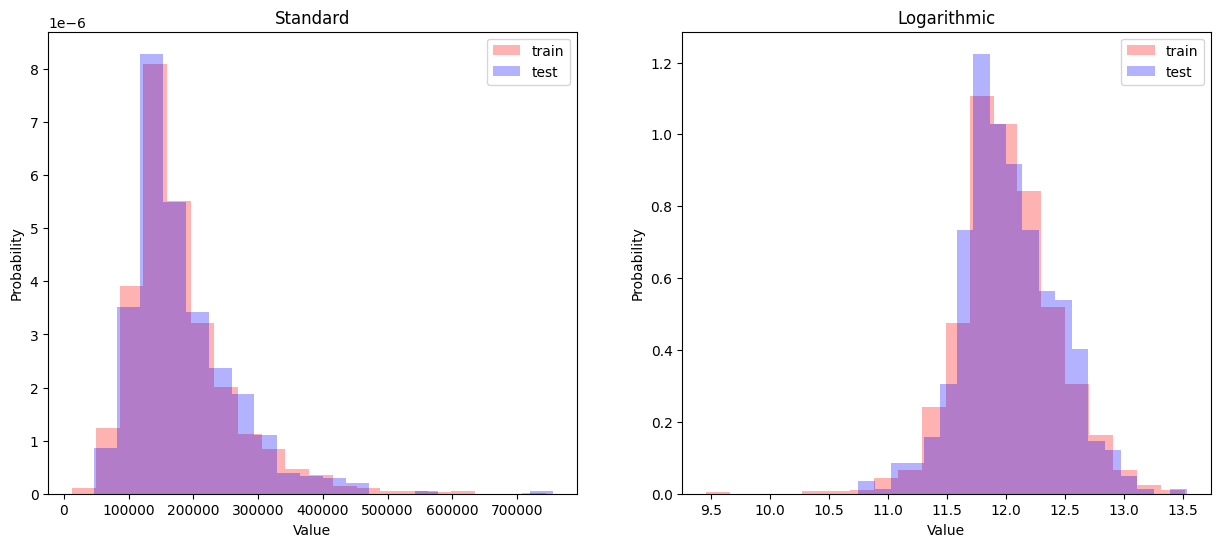

In [17]:
plot_both_distributions(Y_train, Y_test)

Как видите, если прологарифмировать таргеты, то их распределение станет более похоже на гауссовское. Интуиция подсказывает, что линейная регрессия с функцией потерь MSE должна лучше учиться на таких таргетах.

Попробуйте написать класс, который во время обучения логарифмирует таргет, а во время предсказания — наоборот, экспоненциирует. После чего обучите оба метода на обучающих данных и сравните значения метрик MAE и MSLE на тесте.

Что должно быть в этом классе:
- Класс должен называться ```ExponentialLinearRegression```
- Класс должен иметь такой же fit-predict интерфейс, как и было до этого. На вход он получает оригинальные X и Y, а уже внутри происходит логарифмирование или экспоненциирование.
- Внутри этой модели будет работать [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). Хочется, чтобы этому классу можно было передавать аргументы инициализации с помощью *args и **kwargs
- Чтобы потом этот класс можно было использовать в [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) в следующих пунктах, у него должны быть реализованы 5 методов
    1. ```__init__(self, *args, **kwargs)``` &mdash; все полученные аргументы передаются дальше в Ridge.
    2. ```fit(self, X, Y)``` &mdash; обучает класс, возвращает self.
    3. ```predict(self, X)``` &mdash; делает предсказание.
    4. ```get_params(deep=True)``` &mdash; возвращает dict с параметрами модели. Больше подробностей [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html)
    5. ```set_params(**params)``` &mdash; передает нужные параметры в модель. Больше подробносте [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html)
- Есть два подхода к тому как сделать все нужные методы:
    - Отнаследоваться от класса Ridge и переопределить методы fit и predict, внутри вызывая super() от отцовского класса.
    - Отнаследоваться от класса RegressorMixin и внутренним атрибутом класса сделать Ridge. Тогда все методы нужно будет писать руками.

In [18]:
sex_model = Ridge()
sex_model.fit(X_train, Y_train)

sex_model.get_params(deep=True)

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [19]:
class ExponentialLinearRegression(RegressorMixin):
    def __init__(self, *args, **kwargs):
        self.model = Ridge(*args, **kwargs)

    def fit(self, X, Y):
        self.model.fit(X, np.log(Y))

    def predict(self, X):
        return np.exp(self.model.predict(X))

    def get_params(self, *args, **kwargs):
        return self.model.get_params(self, *args, **kwargs)

    def set_params(self, *args, **kwargs):
        self.model.set_params(*args, **kwargs)
        return self.model

**3. (1 балл) Реализуйте этот класс и сдайте в контест**.

In [20]:
classic_regressor = Ridge()
exponential_regressor = ExponentialLinearRegression()

classic_regressor.fit(X_train, Y_train)
exponential_regressor.fit(X_train, Y_train)

classic_prediction = classic_regressor.predict(X_test)
exponential_prediction = exponential_regressor.predict(X_test)

print(f"MAE  : Classic : {mean_absolute_error(Y_test, classic_prediction)}  Exponential : {mean_absolute_error(Y_test, exponential_prediction)}")
print(f"MSLE : Classic : {root_mean_squared_logarithmic_error(Y_test, classic_prediction)} Exponential : {root_mean_squared_logarithmic_error(Y_test, exponential_prediction)}")

MAE  : Classic : 23821.977761006816  Exponential : 26818.69978654439
MSLE : Classic : 0.1950062123328134 Exponential : 0.21601027716185434


4.  Оценка по кросс-валидации

In [21]:
from sklearn.model_selection import cross_validate
from  sklearn.model_selection import KFold

model_lr_cv = LinearRegression()

CV = cross_validate(
    estimator=model_lr_cv,
    X=np.vstack([X_train, X_test]),
    y=np.hstack([Y_train, Y_test]),
    cv=KFold(n_splits=5, shuﬄe=True, random_state=42),
    scoring='neg_mean_absolute_error'
)

In [22]:
cross_val_MAE = CV['test_score'].mean()

print("Cross validation MAE: ", round(-cross_val_MAE))

Cross validation MAE:  23224


Иногда получается так, что разные обученные вами модели приводят к улучшению одних метрик и ухудшению других. Это абсолютно нормально и этому не надо удивляться.

Также зачастую случается так, что прирост по метрике не очень большой. И вы можете захотеть убедиться, что это реальное улучшение, а не просто случайная флуктуация. Для этого можно использовать подсчёт метрики про кросс-валидации, о которой мы поговорим позже в нашем курсе.

### 5. Линейная модель своими руками

В этом разделе вы напишете собственный класс линейной модели, чтобы лучше разобраться, как работает обучение с помощью SGD.

Линейная модель делает предсказание по такой формуле:
$$
\widehat{y}(x) = x^T \widehat{\theta}
$$
Здесь $\widehat{\theta}$ &mdash; обучаемые параметры, $x$ &mdash; вектор фичей данного примера.
Оценка $\widehat{\theta}$ находятся из задачи минимизации лосс функции:

$$
F(\theta) = \frac{1}{n} \sum_{i=1}^{n} \left(Y_i - x_i^T \theta\right)^2 + \lambda \theta^T\theta \longrightarrow \min_{\theta \in \mathbb{R}^d}
$$

Эту задачу минимизации будем решать градиентным спуском. Для этого реализуем этот метод ввиде класса с методами fit-predict.
Что в нем должно быть:
1. Класс должен называться ```SGDLinearRegressor```
2. Класс должен быть отнаследован от sklearn-овского класса [RegressorMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.RegressorMixin.html)
3. Класс должен инициализироваться со следующими гиперпараметрами:

    * ```lr``` — learning rate. Длина шага градиентного спуска

    * ```regularization``` — коэффициент $\lambda$ из формулы выше
    
    * ```delta_converged``` — устанавливает условие окончание обучение. В тот момент когда норма разности весов на соседних шагах градиентного спуска меньше чем ```delta_converged``` метод прекращает обновлять веса
    
    * ```max_steps``` — максимальное число шагов градиентного спуска
    
    * ```batch_size``` — размер батча

4. Реализуйте **стохастический** градиентный спуск. На каждом шагу градиентного спуска должен формироваться батч размера ```batch_size``` из матрицы признаков. Это нужно для того чтобы метод быстрее сходился. Батч может выбираться случайно на каждом шаге градиентного спуска, либо каждую эпоху можно перемешивать трейн выборку и итерироваться батчами по ней.

Обратите внимание при реализации SGD на следующие моменты (частые ошибки):
* не перепутайте, какие коэффициенты в SGD стоят при самой функции потерь, а какие — при регуляризационном члене
* для остановки нужно сравнивать норму, а не ее квадрат
* для правильного решения нужно не итерироваться по батчу,  а перемножать матрицы (иначе не зайдет по TL)

In [23]:
X_train.shape

(2344, 34)

In [24]:
from IPython.display import clear_output
from tqdm import tqdm

In [25]:
import numpy as np
from sklearn.base import RegressorMixin

class SGDLinearRegressor(RegressorMixin):
    def __init__(
        self,
        lr=0.01,
        regularization=1.,
        delta_converged=1e-2,
        max_steps=1000,
        batch_size=64,
    ):
        self.lr = lr
        self.regularization = regularization
        self.max_steps = max_steps
        self.delta_converged = delta_converged
        self.batch_size = batch_size

        self.W = None
        self.b = None   
        self.history = []

    def fit(self, X, Y):
        self.W = np.random.normal(loc=0, scale=1, size=(X.shape[1], 1))
        self.b = np.random.normal(loc=0, scale=1)
        
        is_converged = False
        current_grad_steps = 0
        while not is_converged:
            if current_grad_steps > self.max_steps:
                break
            
            shuffled_indices = np.arange(X.shape[0])
            np.random.shuffle(shuffled_indices)

            X_shuffled = X[shuffled_indices]
            Y_shuffled = Y[shuffled_indices].reshape(Y.shape[0], 1)
            
            batch_start_index = 0
            while batch_start_index + self.batch_size <= X_shuffled.shape[0]:
                X_batch = X_shuffled[batch_start_index : batch_start_index + self.batch_size]
                # (batch_size, D)
                Y_batch = Y_shuffled[batch_start_index : batch_start_index + self.batch_size]
                # (batch_size, 1)
                
                # print("type X_batch: ", type(X_batch))
                # print("type self.W: ", type(self.W))

                f_w = X_batch.dot(self.W) + self.b
                error = f_w - Y_batch
                grad = 2 * X_batch.T.dot(error) / self.batch_size + 2 * self.regularization * self.W
                
                self.history.append(np.square(error).mean())

                assert grad.shape == self.W.shape
                
                self.W -= self.lr * grad
                self.b -= self.lr * error.mean()

                current_grad_steps += 1
                batch_start_index += self.batch_size

    def predict(self, X):
        return (X.dot(self.W) + self.b).reshape(X.shape[0],)

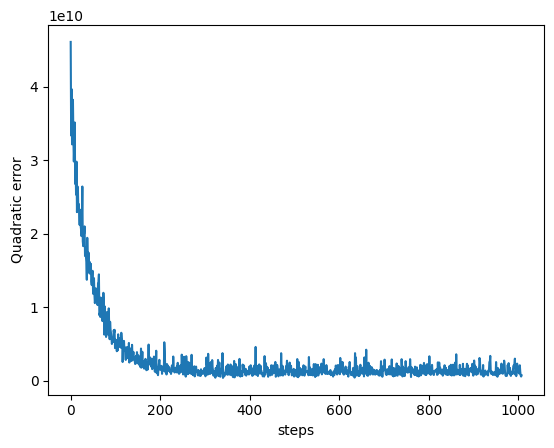

(586,) (586,)
MAE :  25710.87247665645
Mean log :  0.18853418744656544
MAE :  23712.65443010085
Mean log :  0.18407956850093402


In [26]:
# Check yourself

model = SGDLinearRegressor()
model.fit(X_train, Y_train)

plt.plot(model.history)
plt.xlabel('steps')
plt.ylabel('Quadratic error')
plt.show()

prediction = model.predict(X_test)
print(Y_test.shape, prediction.shape)

print("MAE : ", mean_absolute_error(Y_test, prediction))
print("Mean log : ", root_mean_squared_logarithmic_error(Y_test, prediction))

train_prediction = model.predict(X_train)
print("MAE : ", mean_absolute_error(Y_train, train_prediction))
print("Mean log : ", root_mean_squared_logarithmic_error(Y_train, train_prediction))

In [27]:
X_train

array([[ 0.72781797,  0.10999732,  0.65825008, ...,  0.91897402,
         1.59953221, -2.10399441],
       [ 0.28278084,  0.3792301 ,  1.09413674, ...,  1.67878887,
        -0.03026421,  1.46544646],
       [ 0.63881055, -0.1507842 , -0.4147017 , ..., -1.36047053,
         1.4104223 ,  0.21280896],
       ...,
       [ 0.52013398,  0.4287303 , -0.71646938, ..., -0.60065568,
         0.65006975, -0.71551757],
       [ 0.22344256,  0.09261189, -0.4147017 , ...,  0.91897402,
        -0.82561363, -0.89443458],
       [ 0.22344256, -0.36327285, -0.14646375, ...,  0.91897402,
         0.69254025,  0.78026581]])

### 6. Категориальные признаки

В самом начале ноутбука мы отбросили категориальные фичи, хотя они могут помочь нам сделать модель лучше. Давайте же научимся ими пользоваться.

Самый простой подход — это закодировать значения категориального признака числами, скажем, от $0$ до $C-1$, где $C$ — количество значений категориального признака. Иногда это может сработать, но для этого нужно, чтобы между значениями признака были определены отношения больше/меньше (такие признаки называются _ординальными_), причём соотношения между значениями должны быть более-менее линейными. В целом, не очень частая ситуация, поэтому так мы делать не будем.

Вместо этого мы будем использовать OneHotEncoding. Пусть некоторая категориальная фича имеет $C$ уникальных значений. Давайте эту фичу закодируем в виде $C$ столбцов, каждый из которых соответствует некоторому уникальному значению категориальной фичи. Для каждого элемента выборки будем класть единичку в столбец, соответствующий этой фиче, и нолики в остальные.

У этого метода есть недостаток. Если категориальная фича принимает слишком много значений, то вы нагенерируете много новых столбцов, каждый из которых будет содержать мало информации. Из-за них моделька может переобучиться.

Этот метод имплементирован [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). У него есть пара важных гиперпараметров, которые стоит упомянуть:
- ```handle_unknown``` &mdash; управляет обработкой незнакомых категорий на этапе `transform`. Число уникальных значений (и число столбцов) настраивается на обучающей выборке, и при дальнейшем применении может появиться значение, которого ещё не было. Если указать ```handle_unknown="ignore"```, все поля для такого объекта будут заполнены нулями.
- ```drop``` &mdash; если делать one-hot-encoding так как это описано выше, то сумма всех столбцов, соответствующих значениям категориальной фичи, будет равна единичному вектору. А такой вектор уже есть (он соответствует свободному члену). То есть признаки становятся линейно зависимыми, и это сломает процесс обучения линейной модели. Поэтому есть смысл для каждой фичи отбрасывать одну из получившихся колонок (```drop="first"```) или хотя бы делать это только для бинарных фичей (```drop="if_binary"```)

В этом пункте вам надо еще раз предобработать данные, добавив в них часть категориальных фичей, закодированных OneHotEncoding-ом. После этого обучите классификатор заново и выбейте лучшую метрику на тестовой выборке. А именно, мы добавим фичи "Overall_Qual", "Garage_Qual", "Sale_Condition", "MS_Zoning". Используйте значение параметра handle_unknown="ignore".

*Замечание.* На практике в некоторых версиях scikit-learn есть проблема с совместимостью `handle_unknown="ignore"` и `drop="first"` одновременно, поэтому вторым можно пожертвовать.

Класс будет наследоваться от BaseDataPreprocessor, так что в него можно будет передавать нужные для BaseDataPreprocessor параметры. Также это позволит не переписывать заново то, что происходит в базовом классе, а просто взывать к ним с помощью конструкции `super`.

In [28]:
from sklearn.preprocessing import OneHotEncoder

interesting_columns = ["Overall_Qual", "Garage_Qual", "Sale_Condition", "MS_Zoning"]

class OneHotPreprocessor(BaseDataPreprocessor):
    def __init__(self, **kwargs):
        super(OneHotPreprocessor, self).__init__(**kwargs)
        self.one_hot_encoder = OneHotEncoder(
            # drop="first", 
            handle_unknown="ignore"
        )

    def fit(self, data, *args):
        super().fit(data[continuous_columns])
        self.one_hot_encoder.fit(data[interesting_columns])
        self.cat_names = []
        for col_categories in self.one_hot_encoder.categories_:
            for cat in col_categories.tolist():
                self.cat_names.append(cat)

    def transform(self, data):        
        data[continuous_columns] = super().transform(data[continuous_columns])
        
        transform_data = self.one_hot_encoder.transform(data[interesting_columns]).toarray()

        data[self.cat_names] = transform_data

        return data

Обучите модель с добавленными категориальными фичами. Получилось ли улучшить её качество?

In [29]:
model = SGDLinearRegressor()

one_hot_preprocessor = OneHotPreprocessor()
one_hot_preprocessor.fit(data_train)

data_train = one_hot_preprocessor.transform(data_train)

data_train = data_train.select_dtypes(include=['float64']).values

# data_train.drop(interesting_columns, axis=1)

model.fit(data_train, Y_train)

In [30]:
data_train

array([[ 0.72781797,  0.10999732,  0.65825008, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.28278084,  0.3792301 ,  1.09413674, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.63881055, -0.1507842 , -0.4147017 , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.52013398,  0.4287303 , -0.71646938, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.22344256,  0.09261189, -0.4147017 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.22344256, -0.36327285, -0.14646375, ...,  0.        ,
         1.        ,  0.        ]])

In [31]:
# set(data_train.dtypes.values.tolist())

### 7. Pipeline

Представьте ситуацию. Прошел месяц с того момента, как вы построили модель, а теперь вам надо дообучить её на новых данных и активно применять для предсказания. Если вы не позаботились об инфраструктуре, то вам придётся рыскать по всему ноутбуку в поисках того, как вы предобрабатывали данные, какую модель учили, обязательно что-нибудь забудете и будете очень страдать. Поэтому человечество придумало пайплайны, которые позволяют объединить предобработку данных и обучение модели в один класс — pipeline. Его можно писать самому, либо взять из sklearn ([link](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)).

**7. Напишите пайплайн, объединяющий использованную нами базовую предобработку данных (BaseDataPreprocessor и OneHotPreprocessor), а также линейную регрессию с L2-регуляризацией, и сдайте его в Контест.**

In [32]:
def make_ultimate_pipeline():
    # <YOUR CODE HERE>
    pass

В этом пункте вы попробуете сделать что-то поинтереснее и загрузите плоды выших трудов в Контест.

Попробуйте усовершенствовать предобработку данных, добавляя или выкидывая фичи, придумывая функции от признаков так, чтобы улучшить качество классификатора.

Ещё несколько базовых идей о том, что можно было бы попробовать:

- Постройте гистограммы значений признаков. Вы обнаружите, что некоторые из них почти всегда принимают одно и то же значение. Для начала их можно просто выкинуть.
- Почистите выбросы. У некоторых объектов значения каких-то признаков могут сильно выбиваться, и это будет мешать регрессии обучиться. Вообще говоря, такие объекты можно выкидывать, но с текущей архитектурой пайплайна вам будет трудно это настроить. Так что вы можете пока заменять их на более разумные значения.
- Мы добавили лишь несколько категориальных признаков, а на самом деле многие из них могут быть полезными.
- Можно дискретизовать непрерывные фичи. Самый банальный пример: если непрерывная фича принимает всего несколько значений, её можно попробовать проинтерпретировать, как категориальную, и подать в one-hot энкодер. Но можно и как-то ещё разбивать по порогам.
- Можно делать и более сложные преобразования. Например в датасете есть координаты квартиры, которые по идее сами по себе мало чего дают нашему регрессору. С другой стороны, по ним можно оценить центр города (или просто найти его на карте) и использовать в качестве фичи расстояние до центра города, которое может естественным образом влиять на цену жилья.
- Не забывайте настраивать коэффициент регуляризации: для разных датасетов оптимальное значение будет разным.

**В контест вам нужно будет сдать свой класс модели**. Он будет обучаться и тестироваться на новом и неизвестном вам разбиении датасета на трейн и тест по метрике `root_mean_squared_logarithmic_error`. За значение метрики 0.185 вы получите 1 балл (метрика будет округляться до трёх знаков после запятой). Для этого должно быть достаточно нормально написать OneHotPreprocessor и использовать ExponentialLinearRegression с правильно подобранным коэффициентом регуляризации. Если вам удалось получить метрику меньше, то вы получите

`1 + min(1, (0.19 - x) / (0.19 - 0.15))`

балла.

В контесте будет специально проверено, что вы сдаёте именно `Pipeline`.

Не забывайте, что вместе с пайплайном вам нужно отправить и все самописные классы, которые в нём участвуют.
